Total S&P 500 tickers (unique): 503
YF.download() has changed argument auto_adjust default to True


ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=10y)')
ERROR:yfinance:['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")')
<ipython-input-2-91a3068abb4f>:56: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_long["Daily_Return"] = df_long.groupby("Ticker")["Close"].pct_change()


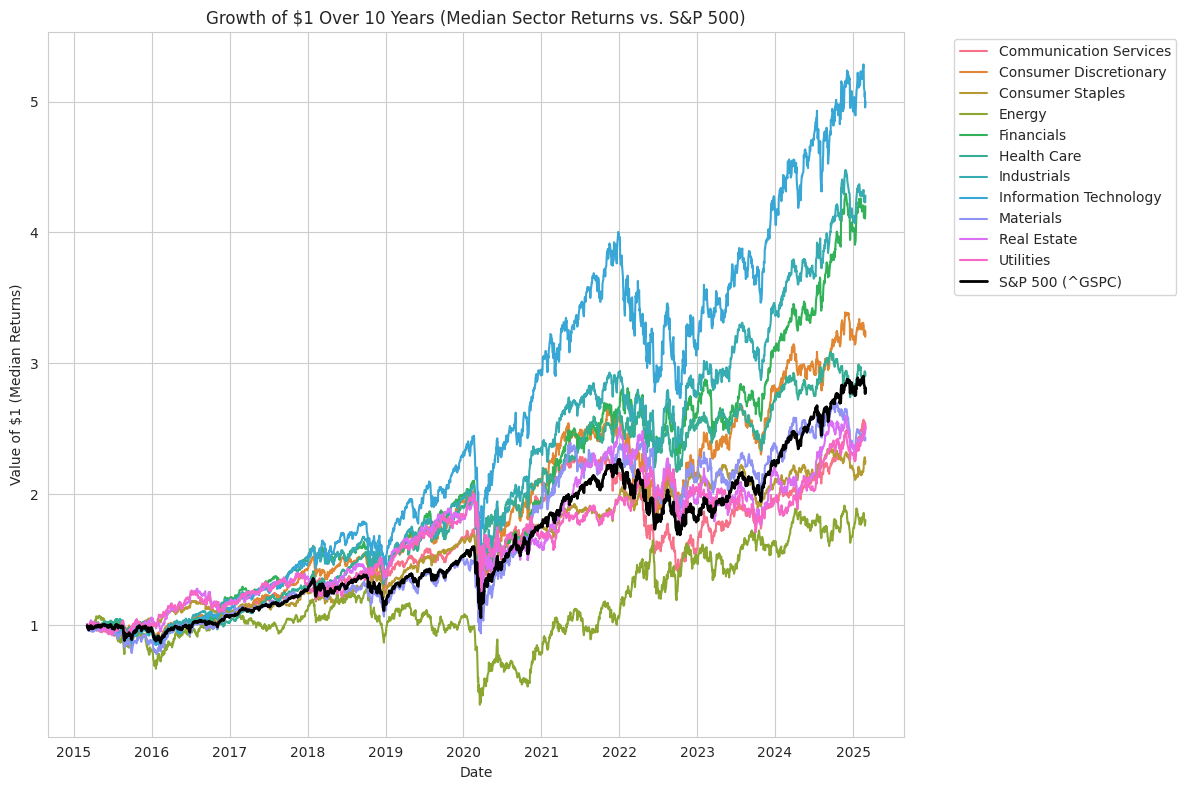


=== Final Value of $1 Invested (Median Sector) ===
GICS Sector
Information Technology    4.999974
Industrials               4.281143
Financials                4.199231
Consumer Discretionary    3.243894
Health Care               2.930674
Utilities                 2.538060
Communication Services    2.525770
Real Estate               2.501938
Materials                 2.434009
Consumer Staples          2.256245
Energy                    1.802062
Name: 2025-02-28 00:00:00, dtype: float64

S&P 500 Final Value of $1 Invested: 2.81


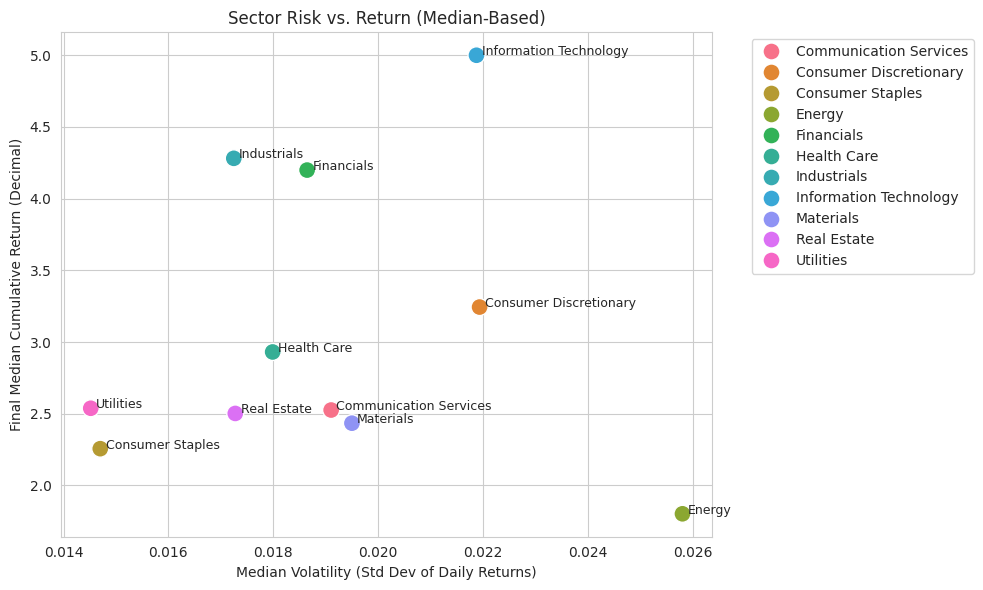

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500 = pd.read_html(url)[0]


sp500_tickers = sp500["Symbol"].unique().tolist()


all_tickers = sp500_tickers + ["^GSPC"]

print(f"Total S&P 500 tickers (unique): {len(sp500_tickers)}")


data = yf.download(
    tickers=all_tickers,
    period="10y",
    interval="1d",
    group_by="ticker",
    progress=False
)


df_long = (
    data
    .stack(level=0, future_stack=True)
    .reset_index()
    .rename(columns={"level_1": "Ticker"})
)


df_long = df_long.merge(
    sp500[["Symbol", "GICS Sector"]],
    left_on="Ticker",
    right_on="Symbol",
    how="left"
)
df_long.drop(columns=["Symbol"], inplace=True)


wanted_cols = ["Date", "Ticker", "GICS Sector", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
available_cols = set(df_long.columns)
final_cols = [c for c in wanted_cols if c in available_cols]
df_long = df_long[final_cols + [col for col in df_long.columns if col not in final_cols]]


df_long["Date"] = pd.to_datetime(df_long["Date"])
df_long.sort_values(by=["Date", "Ticker"], inplace=True)


df_long["Daily_Return"] = df_long.groupby("Ticker")["Close"].pct_change()


df_index = df_long[df_long["Ticker"] == "^GSPC"].copy()
df_stocks = df_long[df_long["Ticker"] != "^GSPC"].copy()


sector_median_returns = (
    df_stocks
    .groupby(["Date", "GICS Sector"])["Daily_Return"]
    .median()
    .dropna()
    .reset_index()
    .pivot(index="Date", columns="GICS Sector", values="Daily_Return")
)


sector_value = (1 + sector_median_returns).cumprod()


df_index.sort_values(by="Date", inplace=True)
df_index["Index_Return"] = df_index["Close"].pct_change()
df_index["Index_Value"] = (1 + df_index["Index_Return"]).cumprod()


plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

colors = sns.color_palette("husl", n_colors=len(sector_value.columns))
for i, sector in enumerate(sector_value.columns):
    plt.plot(sector_value.index, sector_value[sector], label=sector, color=colors[i])


plt.plot(df_index["Date"], df_index["Index_Value"], label="S&P 500 (^GSPC)", color="black", linewidth=2)

plt.title("Growth of $1 Over 10 Years (Median Sector Returns vs. S&P 500)")
plt.xlabel("Date")
plt.ylabel("Value of $1 (Median Returns)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


final_sector_values = sector_value.iloc[-1].sort_values(ascending=False)


final_index_value = df_index["Index_Value"].iloc[-1]

print("\n=== Final Value of $1 Invested (Median Sector) ===")
print(final_sector_values)
print(f"\nS&P 500 Final Value of $1 Invested: {final_index_value:.2f}")


ticker_vol = (
    df_stocks
    .groupby("Ticker")["Daily_Return"]
    .std()
    .reset_index()
    .rename(columns={"Daily_Return": "Volatility"})
)


ticker_sector = df_stocks.drop_duplicates(subset=["Ticker"])[["Ticker", "GICS Sector"]]
ticker_vol = ticker_vol.merge(ticker_sector, on="Ticker", how="left")


median_vol_by_sector = ticker_vol.groupby("GICS Sector")["Volatility"].median()


final_median_cum_return = sector_value.iloc[-1]


scatter_df = pd.DataFrame({
    "Sector": final_median_cum_return.index,
    "Median_Cum_Return": final_median_cum_return.values,
    "Median_Volatility": median_vol_by_sector
}).dropna()


plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.scatterplot(
    data=scatter_df,
    x="Median_Volatility",
    y="Median_Cum_Return",
    hue="Sector",
    palette="husl",
    s=150
)


for i in range(len(scatter_df)):
    plt.text(
        x=scatter_df["Median_Volatility"].iloc[i] + 0.0001,
        y=scatter_df["Median_Cum_Return"].iloc[i],
        s=scatter_df["Sector"].iloc[i],
        fontsize=9
    )

plt.title("Sector Risk vs. Return (Median-Based)")
plt.xlabel("Median Volatility (Std Dev of Daily Returns)")
plt.ylabel("Final Median Cumulative Return (Decimal)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Total S&P 500 tickers (unique): 503


ERROR:yfinance:
15 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y)')
ERROR:yfinance:['DVA', 'GWW', 'USB', 'VZ', 'ZBRA', 'CINF', 'HON', 'VICI', 'ZBH', 'T', 'STT', 'STLD', 'BK']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')
<ipython-input-3-6a6dbda57c90>:56: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_long["Daily_Return"] = df_long.groupby("Ticker")["Close"].pct_change()


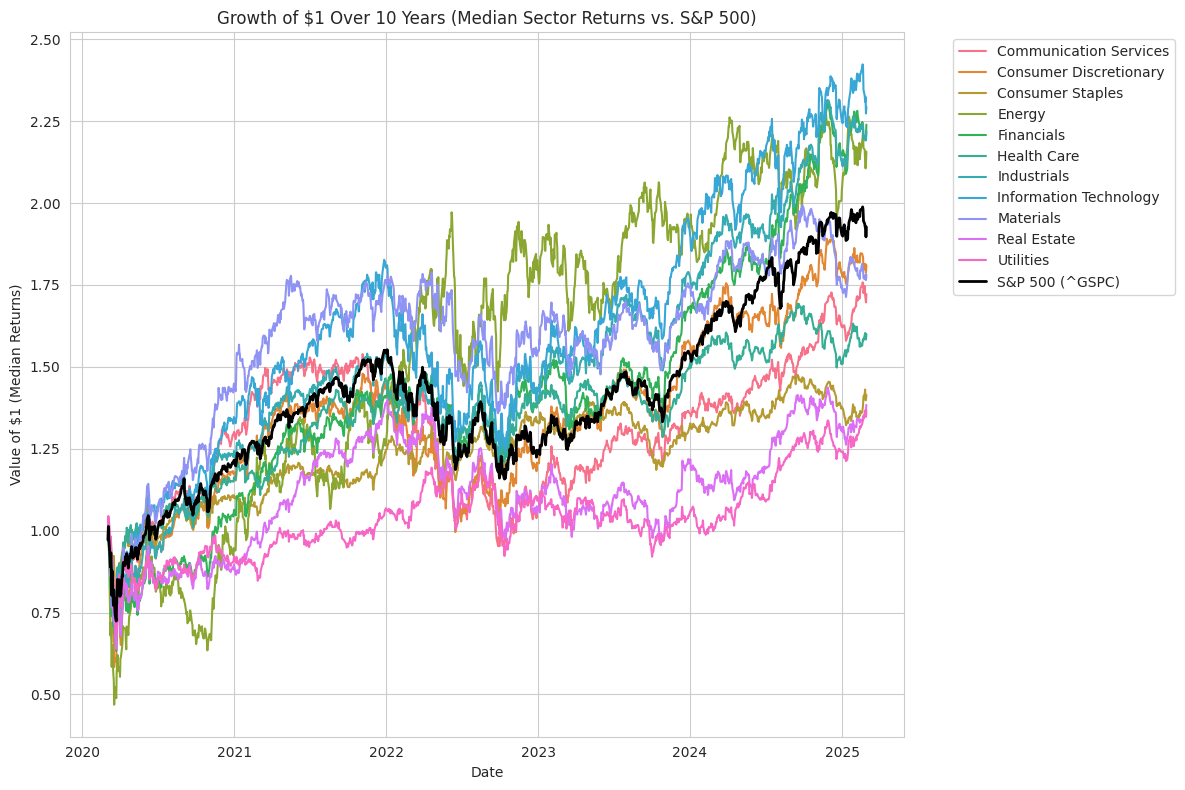


=== Final Value of $1 Invested (Median Sector) ===
GICS Sector
Information Technology    2.293520
Financials                2.239406
Industrials               2.218936
Energy                    2.157132
Consumer Discretionary    1.809863
Materials                 1.781916
Communication Services    1.721938
Health Care               1.599310
Consumer Staples          1.414296
Real Estate               1.383813
Utilities                 1.366800
Name: 2025-02-28 00:00:00, dtype: float64

S&P 500 Final Value of $1 Invested: 1.93


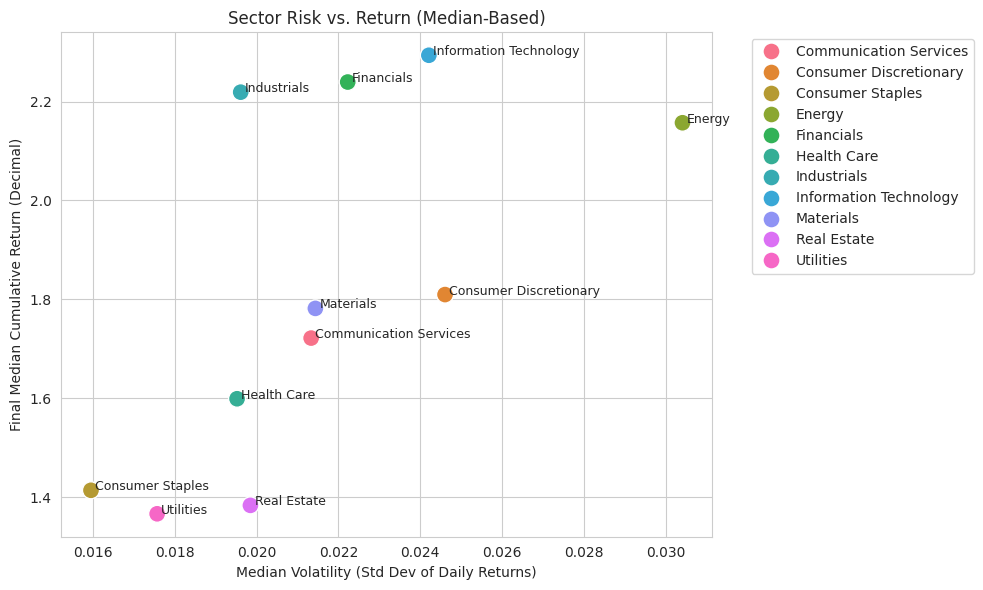

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500 = pd.read_html(url)[0]


sp500_tickers = sp500["Symbol"].unique().tolist()


all_tickers = sp500_tickers + ["^GSPC"]

print(f"Total S&P 500 tickers (unique): {len(sp500_tickers)}")


data = yf.download(
    tickers=all_tickers,
    period="5y",
    interval="1d",
    group_by="ticker",
    progress=False
)


df_long = (
    data
    .stack(level=0, future_stack=True)
    .reset_index()
    .rename(columns={"level_1": "Ticker"})
)

df_long = df_long.merge(
    sp500[["Symbol", "GICS Sector"]],
    left_on="Ticker",
    right_on="Symbol",
    how="left"
)
df_long.drop(columns=["Symbol"], inplace=True)


wanted_cols = ["Date", "Ticker", "GICS Sector", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
available_cols = set(df_long.columns)
final_cols = [c for c in wanted_cols if c in available_cols]
df_long = df_long[final_cols + [col for col in df_long.columns if col not in final_cols]]


df_long["Date"] = pd.to_datetime(df_long["Date"])
df_long.sort_values(by=["Date", "Ticker"], inplace=True)


df_long["Daily_Return"] = df_long.groupby("Ticker")["Close"].pct_change()


df_index = df_long[df_long["Ticker"] == "^GSPC"].copy()
df_stocks = df_long[df_long["Ticker"] != "^GSPC"].copy()


sector_median_returns = (
    df_stocks
    .groupby(["Date", "GICS Sector"])["Daily_Return"]
    .median()
    .dropna()
    .reset_index()
    .pivot(index="Date", columns="GICS Sector", values="Daily_Return")
)


sector_value = (1 + sector_median_returns).cumprod()


df_index.sort_values(by="Date", inplace=True)
df_index["Index_Return"] = df_index["Close"].pct_change()
df_index["Index_Value"] = (1 + df_index["Index_Return"]).cumprod()


plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

colors = sns.color_palette("husl", n_colors=len(sector_value.columns))
for i, sector in enumerate(sector_value.columns):
    plt.plot(sector_value.index, sector_value[sector], label=sector, color=colors[i])


plt.plot(df_index["Date"], df_index["Index_Value"], label="S&P 500 (^GSPC)", color="black", linewidth=2)

plt.title("Growth of $1 Over 10 Years (Median Sector Returns vs. S&P 500)")
plt.xlabel("Date")
plt.ylabel("Value of $1 (Median Returns)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


final_sector_values = sector_value.iloc[-1].sort_values(ascending=False)


final_index_value = df_index["Index_Value"].iloc[-1]

print("\n=== Final Value of $1 Invested (Median Sector) ===")
print(final_sector_values)
print(f"\nS&P 500 Final Value of $1 Invested: {final_index_value:.2f}")


ticker_vol = (
    df_stocks
    .groupby("Ticker")["Daily_Return"]
    .std()
    .reset_index()
    .rename(columns={"Daily_Return": "Volatility"})
)


ticker_sector = df_stocks.drop_duplicates(subset=["Ticker"])[["Ticker", "GICS Sector"]]
ticker_vol = ticker_vol.merge(ticker_sector, on="Ticker", how="left")


median_vol_by_sector = ticker_vol.groupby("GICS Sector")["Volatility"].median()


final_median_cum_return = sector_value.iloc[-1]


scatter_df = pd.DataFrame({
    "Sector": final_median_cum_return.index,
    "Median_Cum_Return": final_median_cum_return.values,
    "Median_Volatility": median_vol_by_sector
}).dropna()


plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.scatterplot(
    data=scatter_df,
    x="Median_Volatility",
    y="Median_Cum_Return",
    hue="Sector",
    palette="husl",
    s=150
)


for i in range(len(scatter_df)):
    plt.text(
        x=scatter_df["Median_Volatility"].iloc[i] + 0.0001,
        y=scatter_df["Median_Cum_Return"].iloc[i],
        s=scatter_df["Sector"].iloc[i],
        fontsize=9
    )

plt.title("Sector Risk vs. Return (Median-Based)")
plt.xlabel("Median Volatility (Std Dev of Daily Returns)")
plt.ylabel("Final Median Cumulative Return (Decimal)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Total S&P 500 tickers (unique): 503


ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=3y)')
ERROR:yfinance:['GRMN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=3y) (Yahoo error = "No data found, symbol may be delisted")')
<ipython-input-4-655edf6fd09f>:56: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_long["Daily_Return"] = df_long.groupby("Ticker")["Close"].pct_change()


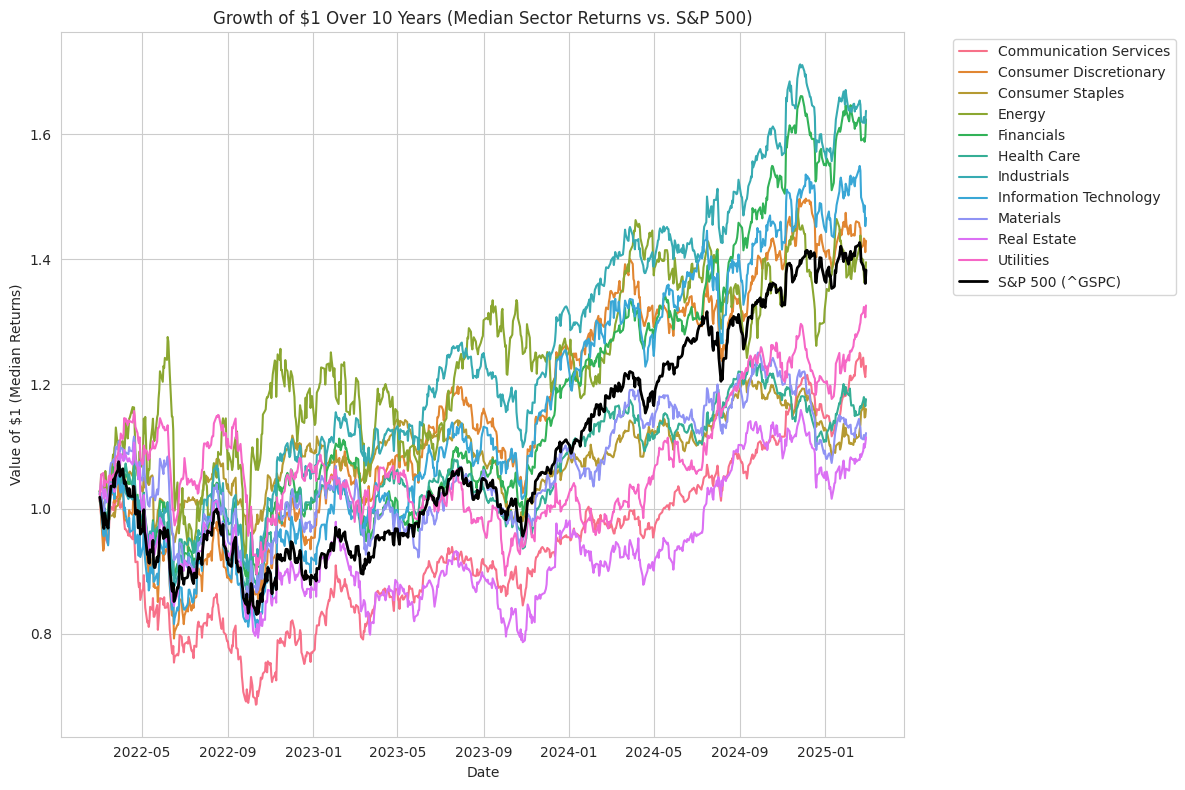


=== Final Value of $1 Invested (Median Sector) ===
GICS Sector
Industrials               1.637814
Financials                1.624176
Information Technology    1.466291
Consumer Discretionary    1.429354
Energy                    1.395304
Utilities                 1.325921
Communication Services    1.229055
Health Care               1.175693
Consumer Staples          1.159819
Materials                 1.121433
Real Estate               1.114586
Name: 2025-02-28 00:00:00, dtype: float64

S&P 500 Final Value of $1 Invested: 1.38


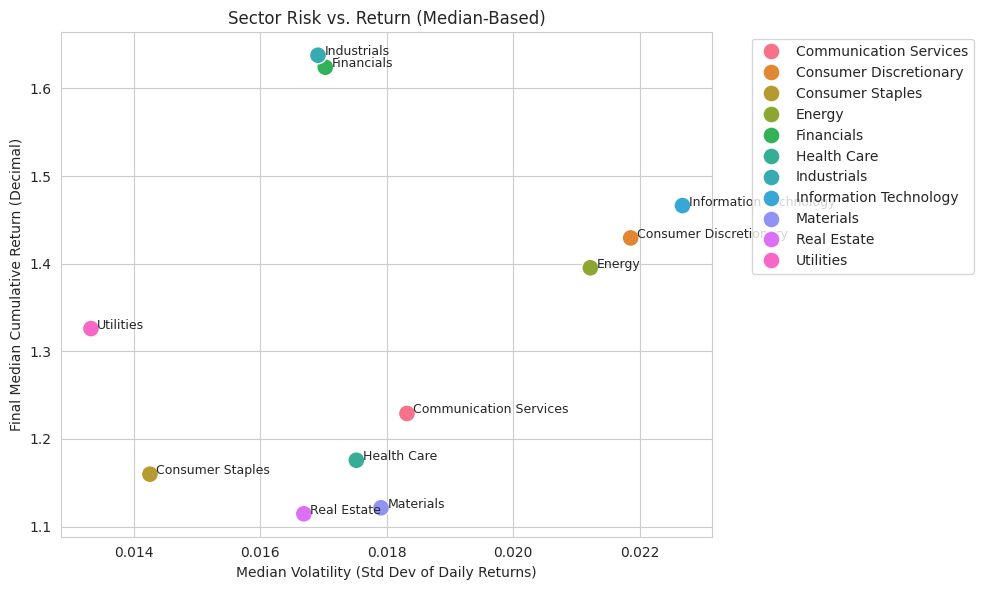

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500 = pd.read_html(url)[0]


sp500_tickers = sp500["Symbol"].unique().tolist()


all_tickers = sp500_tickers + ["^GSPC"]

print(f"Total S&P 500 tickers (unique): {len(sp500_tickers)}")


data = yf.download(
    tickers=all_tickers,
    period="3y",
    interval="1d",
    group_by="ticker",
    progress=False
)


df_long = (
    data
    .stack(level=0, future_stack=True)
    .reset_index()
    .rename(columns={"level_1": "Ticker"})
)


df_long = df_long.merge(
    sp500[["Symbol", "GICS Sector"]],
    left_on="Ticker",
    right_on="Symbol",
    how="left"
)
df_long.drop(columns=["Symbol"], inplace=True)


wanted_cols = ["Date", "Ticker", "GICS Sector", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
available_cols = set(df_long.columns)
final_cols = [c for c in wanted_cols if c in available_cols]
df_long = df_long[final_cols + [col for col in df_long.columns if col not in final_cols]]


df_long["Date"] = pd.to_datetime(df_long["Date"])
df_long.sort_values(by=["Date", "Ticker"], inplace=True)


df_long["Daily_Return"] = df_long.groupby("Ticker")["Close"].pct_change()


df_index = df_long[df_long["Ticker"] == "^GSPC"].copy()
df_stocks = df_long[df_long["Ticker"] != "^GSPC"].copy()

sector_median_returns = (
    df_stocks
    .groupby(["Date", "GICS Sector"])["Daily_Return"]
    .median()
    .dropna()
    .reset_index()
    .pivot(index="Date", columns="GICS Sector", values="Daily_Return")
)


sector_value = (1 + sector_median_returns).cumprod()

df_index.sort_values(by="Date", inplace=True)
df_index["Index_Return"] = df_index["Close"].pct_change()
df_index["Index_Value"] = (1 + df_index["Index_Return"]).cumprod()


plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

colors = sns.color_palette("husl", n_colors=len(sector_value.columns))
for i, sector in enumerate(sector_value.columns):
    plt.plot(sector_value.index, sector_value[sector], label=sector, color=colors[i])

plt.plot(df_index["Date"], df_index["Index_Value"], label="S&P 500 (^GSPC)", color="black", linewidth=2)

plt.title("Growth of $1 Over 10 Years (Median Sector Returns vs. S&P 500)")
plt.xlabel("Date")
plt.ylabel("Value of $1 (Median Returns)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


final_sector_values = sector_value.iloc[-1].sort_values(ascending=False)


final_index_value = df_index["Index_Value"].iloc[-1]

print("\n=== Final Value of $1 Invested (Median Sector) ===")
print(final_sector_values)
print(f"\nS&P 500 Final Value of $1 Invested: {final_index_value:.2f}")


ticker_vol = (
    df_stocks
    .groupby("Ticker")["Daily_Return"]
    .std()
    .reset_index()
    .rename(columns={"Daily_Return": "Volatility"})
)


ticker_sector = df_stocks.drop_duplicates(subset=["Ticker"])[["Ticker", "GICS Sector"]]
ticker_vol = ticker_vol.merge(ticker_sector, on="Ticker", how="left")


median_vol_by_sector = ticker_vol.groupby("GICS Sector")["Volatility"].median()


final_median_cum_return = sector_value.iloc[-1]


scatter_df = pd.DataFrame({
    "Sector": final_median_cum_return.index,
    "Median_Cum_Return": final_median_cum_return.values,
    "Median_Volatility": median_vol_by_sector
}).dropna()


plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.scatterplot(
    data=scatter_df,
    x="Median_Volatility",
    y="Median_Cum_Return",
    hue="Sector",
    palette="husl",
    s=150
)


for i in range(len(scatter_df)):
    plt.text(
        x=scatter_df["Median_Volatility"].iloc[i] + 0.0001,
        y=scatter_df["Median_Cum_Return"].iloc[i],
        s=scatter_df["Sector"].iloc[i],
        fontsize=9
    )

plt.title("Sector Risk vs. Return (Median-Based)")
plt.xlabel("Median Volatility (Std Dev of Daily Returns)")
plt.ylabel("Final Median Cumulative Return (Decimal)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


[*********************100%***********************]  69 of 69 completed
<ipython-input-5-559cc27bc729>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, ax=ax2, palette="Blues_r")



Median Cumulative Return (2012–2022) for All Tech Stocks: 723.40%
Number of Tech Stocks with Data: 69


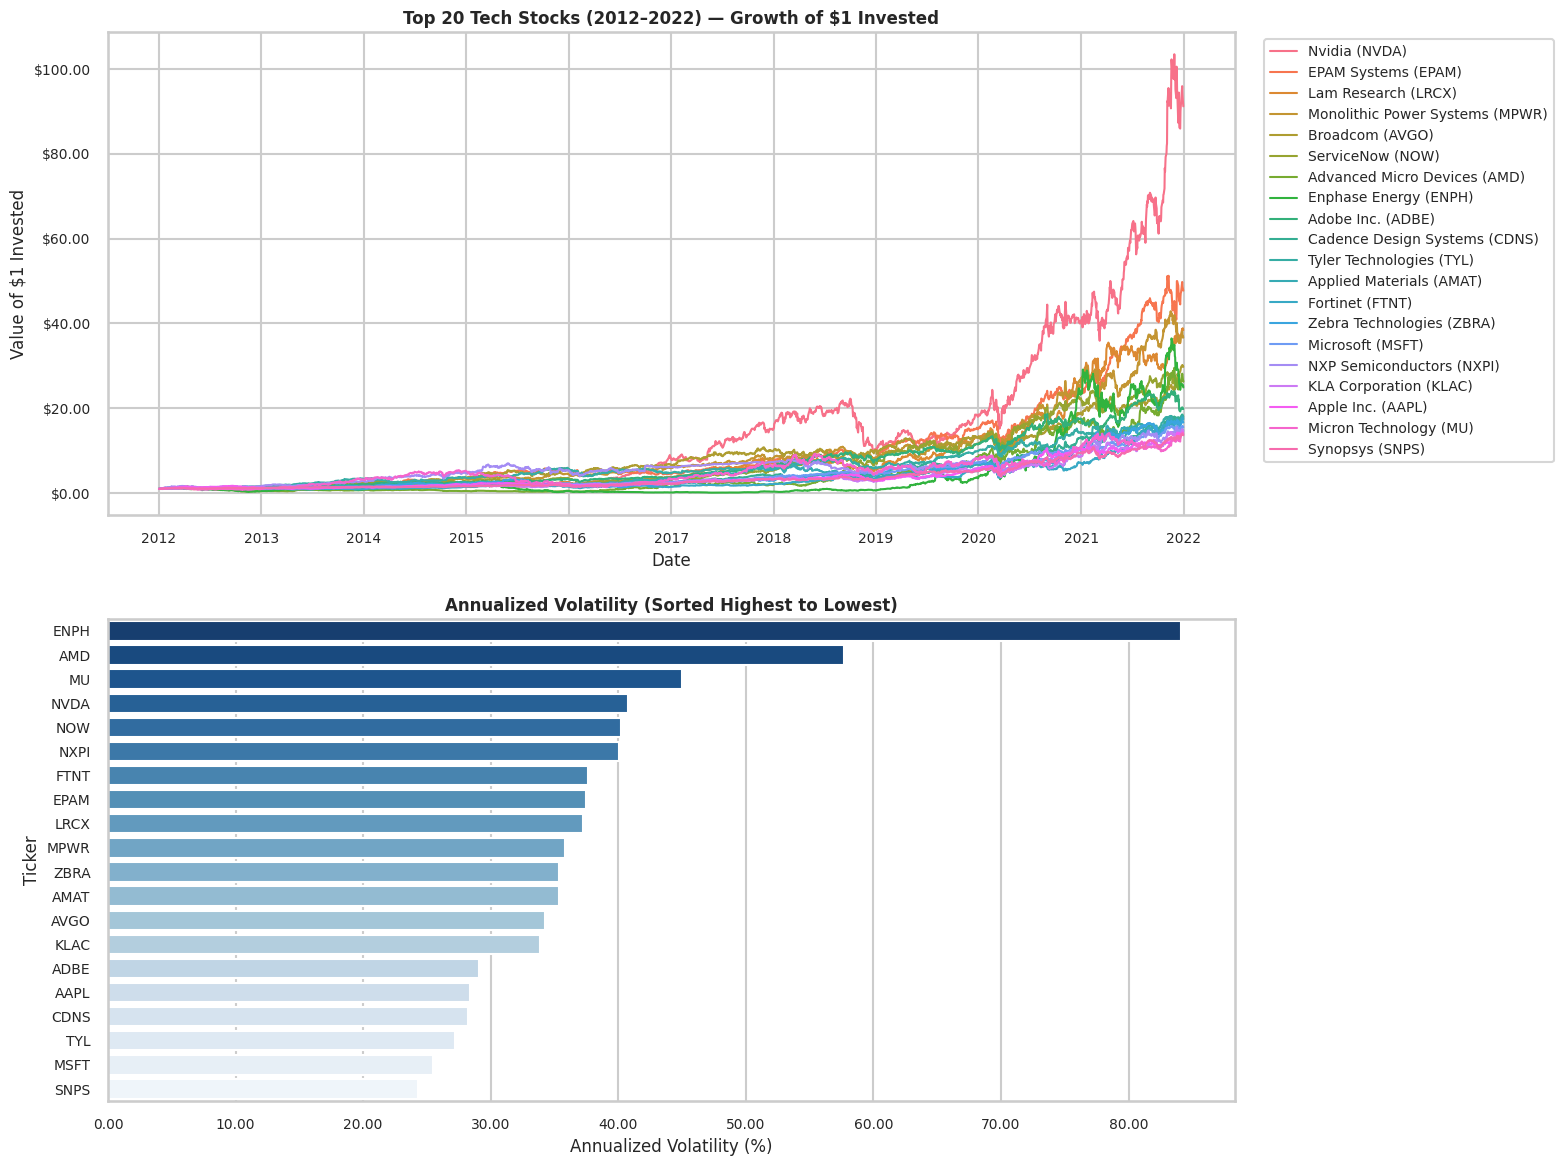

In [ ]:
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
sns.set_theme(style="whitegrid", context="talk")


url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500 = pd.read_html(url, header=0)[0]
tech_stocks = sp500[sp500['GICS Sector'] == 'Information Technology']
tickers = tech_stocks['Symbol'].tolist()
name_map = dict(zip(tech_stocks['Symbol'], tech_stocks['Security']))


start_date = datetime(2012, 1, 1)
end_date   = datetime(2022, 1, 1)
df_full = yf.download(tickers, start=start_date, end=end_date)

if "Adj Close" in df_full.columns.levels[0]:
    df_prices = df_full["Adj Close"]
else:
    df_prices = df_full["Close"]


stats = {}
for ticker in df_prices.columns:
    series = df_prices[ticker].dropna()
    if len(series) < 2:
        continue

    final_return = (series.iloc[-1] / series.iloc[0]) - 1
    daily_ret = series.pct_change().dropna()
    if len(daily_ret) == 0:
        continue

    ann_vol = daily_ret.std() * np.sqrt(252)
    stats[ticker] = {"final_return": final_return, "annualized_vol": ann_vol}

stats_df = pd.DataFrame.from_dict(stats, orient='index')
stats_df.index.name = "Ticker"


all_median = stats_df["final_return"].median()
print(f"\nMedian Cumulative Return (2012–2022) for All Tech Stocks: {all_median:.2%}")
print(f"Number of Tech Stocks with Data: {len(stats_df)}")


stats_df.sort_values("final_return", ascending=False, inplace=True)
top_20 = stats_df.head(20)


df_value = pd.DataFrame(index=df_prices.index)
for ticker in top_20.index:
    s = df_prices[ticker].dropna()
    if len(s) >= 2:
        df_value[ticker] = s / s.iloc[0]
df_value.dropna(how='all', inplace=True)


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))


colors = sns.color_palette("husl", n_colors=len(df_value.columns))
for i, ticker in enumerate(df_value.columns):
    label = f"{name_map.get(ticker, 'Unknown')} ({ticker})"
    ax1.plot(df_value.index, df_value[ticker], label=label, linewidth=1.5, color=colors[i])

ax1.set_title("Top 20 Tech Stocks (2012–2022) — Growth of $1 Invested", fontsize=12, fontweight='bold')
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Value of $1 Invested", fontsize=12)
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('$%.2f'))
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)


ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)


top_20_sorted_vol = top_20.sort_values("annualized_vol", ascending=False)
x = top_20_sorted_vol.index
y = top_20_sorted_vol["annualized_vol"] * 100

sns.barplot(x=y, y=x, ax=ax2, palette="Blues_r")
ax2.set_title("Annualized Volatility (Sorted Highest to Lowest)", fontsize=12, fontweight='bold')
ax2.set_xlabel("Annualized Volatility (%)", fontsize=12)
ax2.set_ylabel("Ticker", fontsize=12)


ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))


ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()


## Next section will be looking at is more detail

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set_theme(style="whitegrid")


url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url, header=0)[0]
tech_df = sp500_table[sp500_table['GICS Sector'] == 'Information Technology']
tech_tickers = tech_df['Symbol'].tolist()

tech_tickers = [ticker.replace('.', '-') for ticker in tech_tickers]


start_date = "2012-01-01"
end_date = "2022-01-01"
data = yf.download(tech_tickers, start=start_date, end=end_date, progress=False)


results = []
for ticker in tech_tickers:
    try:
        if ticker not in data['Close'].columns:
            print(f"{ticker} not found in data['Close'] columns")
            continue

        series = data['Close'][ticker].dropna()
        if series.empty:
            continue


        cum_return = (series.iloc[-1] / series.iloc[0]) - 1


        daily_returns = series.pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252)


        if volatility != 0:
            ratio = cum_return / volatility
        else:
            ratio = np.nan

        results.append({
            'Ticker': ticker,
            'Cumulative Return': cum_return,
            'Volatility': volatility,
            'Return-to-Risk': ratio
        })
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

_results_10y = pd.DataFrame(results)

_results_10y

,Ticker,Cumulative Return,Volatility,Return-to-Risk
0,ACN,8.481823,0.227254,37.323151
1,ADBE,18.848093,0.290675,64.842404
2,AMD,25.259123,0.576767,43.794353
3,AKAM,2.554206,0.336724,7.585468
4,APH,7.333410,0.231111,31.731049
...,...,...,...,...
64,TYL,16.730719,0.271605,61.599434
65,VRSN,6.085986,0.255227,23.845430
66,WDC,1.692043,0.426651,3.965872
67,WDAY,4.610598,0.383297,12.028787


In [ ]:

sns.set_theme(style="whitegrid")


url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url, header=0)[0]
tech_df = sp500_table[sp500_table['GICS Sector'] == 'Information Technology']
tech_tickers = tech_df['Symbol'].tolist()
tech_tickers = [ticker.replace('.', '-') for ticker in tech_tickers]


start_date = "2017-01-01"
end_date = "2022-01-01"
data = yf.download(tech_tickers, start=start_date, end=end_date, progress=False)


results_5y = []
for ticker in tech_tickers:
    try:
        if ticker not in data['Close'].columns:
            print(f"{ticker} not found in data['Close'] columns")
            continue

        series = data['Close'][ticker].dropna()
        if series.empty:
            continue


        cum_return = (series.iloc[-1] / series.iloc[0]) - 1


        daily_returns = series.pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252)


        ratio = np.nan if volatility == 0 else (cum_return / volatility)

        results_5y.append({
            'Ticker': ticker,
            'Cumulative Return': cum_return,
            'Volatility': volatility,
            'Return-to-Risk': ratio
        })
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

_results_5y = pd.DataFrame(results_5y)


In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set_theme(style="whitegrid")


url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url, header=0)[0]
tech_df = sp500_table[sp500_table['GICS Sector'] == 'Information Technology']
tech_tickers = tech_df['Symbol'].tolist()
tech_tickers = [ticker.replace('.', '-') for ticker in tech_tickers]


start_date = "2019-01-01"
end_date = "2022-01-01"
data = yf.download(tech_tickers, start=start_date, end=end_date, progress=False)


results_3y = []
for ticker in tech_tickers:
    try:
        if ticker not in data['Close'].columns:
            print(f"{ticker} not found in data['Close'] columns")
            continue

        series = data['Close'][ticker].dropna()
        if series.empty:
            continue


        cum_return = (series.iloc[-1] / series.iloc[0]) - 1


        daily_returns = series.pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252)


        ratio = np.nan if volatility == 0 else (cum_return / volatility)

        results_3y.append({
            'Ticker': ticker,
            'Cumulative Return': cum_return,
            'Volatility': volatility,
            'Return-to-Risk': ratio
        })
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

_results_3y = pd.DataFrame(results_3y)


In [ ]:

sns.set_theme(style="whitegrid")


url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url, header=0)[0]
tech_df = sp500_table[sp500_table['GICS Sector'] == 'Information Technology']
tech_tickers = tech_df['Symbol'].tolist()
tech_tickers = [ticker.replace('.', '-') for ticker in tech_tickers]


start_date = "2021-01-01"
end_date = "2022-01-01"
data = yf.download(tech_tickers, start=start_date, end=end_date, progress=False)


results_1y = []
for ticker in tech_tickers:
    try:
        if ticker not in data['Close'].columns:
            print(f"{ticker} not found in data['Close'] columns")
            continue

        series = data['Close'][ticker].dropna()
        if series.empty:
            continue


        cum_return = (series.iloc[-1] / series.iloc[0]) - 1


        daily_returns = series.pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252)


        ratio = np.nan if volatility == 0 else (cum_return / volatility)

        results_1y.append({
            'Ticker': ticker,
            'Cumulative Return': cum_return,
            'Volatility': volatility,
            'Return-to-Risk': ratio
        })
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

_results_1y = pd.DataFrame(results_1y)


In [ ]:

_results_10y = _results_10y.rename(columns={
    "Cumulative Return": "CumulativeReturn_10y",
    "Volatility": "Volatility_10y",
    "Return-to-Risk": "ReturnToRisk_10y"
})

_results_5y = _results_5y.rename(columns={
    "Cumulative Return": "CumulativeReturn_5y",
    "Volatility": "Volatility_5y",
    "Return-to-Risk": "ReturnToRisk_5y"
})

_results_3y = _results_3y.rename(columns={
    "Cumulative Return": "CumulativeReturn_3y",
    "Volatility": "Volatility_3y",
    "Return-to-Risk": "ReturnToRisk_3y"
})

_results_1y = _results_1y.rename(columns={
    "Cumulative Return": "CumulativeReturn_1y",
    "Volatility": "Volatility_1y",
    "Return-to-Risk": "ReturnToRisk_1y"
})


df_10y = _results_10y[["Ticker","CumulativeReturn_10y","Volatility_10y","ReturnToRisk_10y"]]
df_5y  = _results_5y[ ["Ticker","CumulativeReturn_5y","Volatility_5y","ReturnToRisk_5y"]]
df_3y  = _results_3y[ ["Ticker","CumulativeReturn_3y","Volatility_3y","ReturnToRisk_3y"]]
df_1y  = _results_1y[ ["Ticker","CumulativeReturn_1y","Volatility_1y","ReturnToRisk_1y"]]

merged_df = (
    df_10y.merge(df_5y, on="Ticker", how="inner")
          .merge(df_3y, on="Ticker", how="inner")
          .merge(df_1y, on="Ticker", how="inner")
)

print("Merged shape:", merged_df.shape)
print(merged_df.head())



Merged shape: (69, 13)


,Ticker,CumulativeReturn_10y,Volatility_10y,ReturnToRisk_10y,CumulativeReturn_5y,Volatility_5y,ReturnToRisk_5y,CumulativeReturn_3y,Volatility_3y,ReturnToRisk_3y,CumulativeReturn_1y,Volatility_1y,ReturnToRisk_1y
0,ACN,8.481823,0.227254,37.323151,2.850627,0.250199,11.393426,2.071274,0.283698,7.300986,0.636411,0.196686,3.235666
1,ADBE,18.848093,0.290675,64.842404,4.479899,0.330242,13.565517,1.525092,0.352362,4.328197,0.168377,0.292368,0.575908
2,AMD,25.259123,0.576767,43.794353,11.589675,0.562022,20.621388,6.642060,0.530311,12.524836,0.559046,0.426119,1.311948
3,AKAM,2.554206,0.336724,7.585468,0.732130,0.307345,2.382108,0.983393,0.292138,3.366188,0.112125,0.254791,0.440066
4,APH,7.333410,0.231111,31.731049,1.720325,0.250304,6.872953,1.256861,0.292145,4.302185,0.373052,0.207220,1.800270


In [ ]:
import numpy as np


cumret_cols = ["CumulativeReturn_10y","CumulativeReturn_5y","CumulativeReturn_3y","CumulativeReturn_1y"]
vol_cols    = ["Volatility_10y","Volatility_5y","Volatility_3y","Volatility_1y"]
rtr_cols    = ["ReturnToRisk_10y","ReturnToRisk_5y","ReturnToRisk_3y","ReturnToRisk_1y"]

def zscore(series):
    return (series - series.mean()) / series.std(ddof=0)


for col in cumret_cols + vol_cols + rtr_cols:
    if merged_df[col].std(ddof=0) == 0:

        merged_df["z_"+col] = 0
    else:
        merged_df["z_"+col] = zscore(merged_df[col])


for col in vol_cols:
    merged_df["z_"+col] = -1.0 * merged_df["z_"+col]

metric_weights = {
    "CumulativeReturn": 0.4,
    "Volatility":       0.3,
    "ReturnToRisk":     0.3
}

time_weights = {
    "10y": 0.4,
    "5y":  0.3,
    "3y":  0.2,
    "1y":  0.1
}

def compute_score(row):
    score = 0.0


    for tf in ["10y","5y","3y","1y"]:

        cr_col  = f"z_CumulativeReturn_{tf}"
        vol_col = f"z_Volatility_{tf}"
        rtr_col = f"z_ReturnToRisk_{tf}"


        tf_sum = (metric_weights["CumulativeReturn"] * row[cr_col]
                  + metric_weights["Volatility"]       * row[vol_col]
                  + metric_weights["ReturnToRisk"]     * row[rtr_col])


        score += time_weights[tf] * tf_sum

    return score

merged_df["FinalScore"] = merged_df.apply(compute_score, axis=1)


merged_df.sort_values("FinalScore", ascending=False, inplace=True)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
import optuna


_results_10y = _results_10y.rename(columns={
    "Cumulative Return": "CumulativeReturn_10y",
    "Volatility": "Volatility_10y",
    "Return-to-Risk": "ReturnToRisk_10y"
})
_results_5y = _results_5y.rename(columns={
    "Cumulative Return": "CumulativeReturn_5y",
    "Volatility": "Volatility_5y",
    "Return-to-Risk": "ReturnToRisk_5y"
})
_results_3y = _results_3y.rename(columns={
    "Cumulative Return": "CumulativeReturn_3y",
    "Volatility": "Volatility_3y",
    "Return-to-Risk": "ReturnToRisk_3y"
})
_results_1y = _results_1y.rename(columns={
    "Cumulative Return": "CumulativeReturn_1y",
    "Volatility": "Volatility_1y",
    "Return-to-Risk": "ReturnToRisk_1y"
})


df_10y = _results_10y[["Ticker","CumulativeReturn_10y","Volatility_10y","ReturnToRisk_10y"]]
df_5y  = _results_5y[ ["Ticker","CumulativeReturn_5y","Volatility_5y","ReturnToRisk_5y"]]
df_3y  = _results_3y[ ["Ticker","CumulativeReturn_3y","Volatility_3y","ReturnToRisk_3y"]]
df_1y  = _results_1y[ ["Ticker","CumulativeReturn_1y","Volatility_1y","ReturnToRisk_1y"]]

merged_df = (df_10y.merge(df_5y, on="Ticker", how="inner")
                     .merge(df_3y, on="Ticker", how="inner")
                     .merge(df_1y, on="Ticker", how="inner"))


def zscore(series):
    return (series - series.mean()) / series.std(ddof=0)


cumret_cols = ["CumulativeReturn_10y","CumulativeReturn_5y","CumulativeReturn_3y","CumulativeReturn_1y"]
vol_cols    = ["Volatility_10y","Volatility_5y","Volatility_3y","Volatility_1y"]
rtr_cols    = ["ReturnToRisk_10y","ReturnToRisk_5y","ReturnToRisk_3y","ReturnToRisk_1y"]

for col in cumret_cols + vol_cols + rtr_cols:
    if merged_df[col].std(ddof=0) == 0:
        merged_df["z_"+col] = 0
    else:
        merged_df["z_"+col] = zscore(merged_df[col])


for col in vol_cols:
    merged_df["z_"+col] = -1.0 * merged_df["z_"+col]


def objective(trial):

    w_cr  = trial.suggest_float("w_cr",  0.0, 1.0)
    w_vol = trial.suggest_float("w_vol", 0.0, 1.0)
    w_rtr = trial.suggest_float("w_rtr", 0.0, 1.0)
    sum_m = w_cr + w_vol + w_rtr
    if sum_m == 0:
        return -9999
    w_cr  /= sum_m
    w_vol /= sum_m
    w_rtr /= sum_m


    w_10y = trial.suggest_float("w_10y", 0.0, 1.0)
    w_5y  = trial.suggest_float("w_5y",  0.0, 1.0)
    w_3y  = trial.suggest_float("w_3y",  0.0, 1.0)
    w_1y  = trial.suggest_float("w_1y",  0.0, 1.0)
    sum_tf = w_10y + w_5y + w_3y + w_1y
    if sum_tf == 0:
        return -9999
    w_10y /= sum_tf
    w_5y  /= sum_tf
    w_3y  /= sum_tf
    w_1y  /= sum_tf


    df = merged_df.copy()

    def combined_score(row):

        score_10y = w_10y * (w_cr*row["z_CumulativeReturn_10y"] + w_vol*row["z_Volatility_10y"] + w_rtr*row["z_ReturnToRisk_10y"])
        score_5y  = w_5y  * (w_cr*row["z_CumulativeReturn_5y"]  + w_vol*row["z_Volatility_5y"]  + w_rtr*row["z_ReturnToRisk_5y"])
        score_3y  = w_3y  * (w_cr*row["z_CumulativeReturn_3y"]  + w_vol*row["z_Volatility_3y"]  + w_rtr*row["z_ReturnToRisk_3y"])
        score_1y  = w_1y  * (w_cr*row["z_CumulativeReturn_1y"]  + w_vol*row["z_Volatility_1y"]  + w_rtr*row["z_ReturnToRisk_1y"])
        return score_10y + score_5y + score_3y + score_1y

    df["combined_score"] = df.apply(combined_score, axis=1)


    top_10 = df.nlargest(10, "combined_score")


    if all(col in df.columns for col in ["ReturnToRisk_10y","ReturnToRisk_5y","ReturnToRisk_3y","ReturnToRisk_1y"]):
        avg_rtr_10y = top_10["ReturnToRisk_10y"].mean()
        avg_rtr_5y  = top_10["ReturnToRisk_5y"].mean()
        avg_rtr_3y  = top_10["ReturnToRisk_3y"].mean()
        avg_rtr_1y  = top_10["ReturnToRisk_1y"].mean()

        objective_value = np.mean([avg_rtr_10y, avg_rtr_5y, avg_rtr_3y, avg_rtr_1y])
    else:

        avg_zrtr_10y = top_10["z_ReturnToRisk_10y"].mean()
        avg_zrtr_5y  = top_10["z_ReturnToRisk_5y"].mean()
        avg_zrtr_3y  = top_10["z_ReturnToRisk_3y"].mean()
        avg_zrtr_1y  = top_10["z_ReturnToRisk_1y"].mean()
        objective_value = np.mean([avg_zrtr_10y, avg_zrtr_5y, avg_zrtr_3y, avg_zrtr_1y])


    return objective_value
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)
print("Best objective value:", study.best_value)


best_params = study.best_params


w_cr  = best_params["w_cr"]
w_vol = best_params["w_vol"]
w_rtr = best_params["w_rtr"]
sum_m = w_cr + w_vol + w_rtr
if sum_m == 0:
    w_cr = w_vol = w_rtr = 1/3.0
else:
    w_cr  /= sum_m
    w_vol /= sum_m
    w_rtr /= sum_m


w_10y = best_params["w_10y"]
w_5y  = best_params["w_5y"]
w_3y  = best_params["w_3y"]
w_1y  = best_params["w_1y"]
sum_tf = w_10y + w_5y + w_3y + w_1y
if sum_tf == 0:
    w_10y = 0.4
    w_5y  = 0.3
    w_3y  = 0.2
    w_1y  = 0.1
else:
    w_10y /= sum_tf
    w_5y  /= sum_tf
    w_3y  /= sum_tf
    w_1y  /= sum_tf


df = merged_df.copy()

def combined_score(row):
    score_10y = w_10y * (
        w_cr  * row["z_CumulativeReturn_10y"] +
        w_vol * row["z_Volatility_10y"]       +
        w_rtr * row["z_ReturnToRisk_10y"]
    )
    score_5y = w_5y * (
        w_cr  * row["z_CumulativeReturn_5y"] +
        w_vol * row["z_Volatility_5y"]       +
        w_rtr * row["z_ReturnToRisk_5y"]
    )
    score_3y = w_3y * (
        w_cr  * row["z_CumulativeReturn_3y"] +
        w_vol * row["z_Volatility_3y"]       +
        w_rtr * row["z_ReturnToRisk_3y"]
    )
    score_1y = w_1y * (
        w_cr  * row["z_CumulativeReturn_1y"] +
        w_vol * row["z_Volatility_1y"]       +
        w_rtr * row["z_ReturnToRisk_1y"]
    )
    return score_10y + score_5y + score_3y + score_1y

df["combined_score"] = df.apply(combined_score, axis=1)


df.sort_values("combined_score", ascending=False, inplace=True)


top_20 = df.head(20)

print("\n=== Top 20 Stocks Using Optuna-Tuned Weights ===")
print(top_20[["Ticker","combined_score"]])


Best hyperparameters: {'w_cr': 0.2722266780606686, 'w_vol': 0.10889042075193557, 'w_rtr': 0.8743760883499054, 'w_10y': 0.8416592751065395, 'w_5y': 0.7954511376185788, 'w_3y': 0.37438115154934315, 'w_1y': 0.00233820233242521}
Best objective value: 35.36825249629979

=== Top 20 Stocks Using Optuna-Tuned Weights ===
   Ticker  combined_score
19   ENPH        3.764740
44   NVDA        2.537266
20   EPAM        1.382689
37   LRCX        1.004633
41   MPWR        0.790119
11   AVGO        0.540823
12   CDNS        0.514199
55    NOW        0.476016
24   FTNT        0.457251
40   MSFT        0.440262
58   SNPS        0.439474
7    AAPL        0.393728
64    TYL        0.373873
2     AMD        0.372980
1    ADBE        0.359506
32   INTU        0.269922
68   ZBRA        0.230284
8    AMAT        0.192457
36   KLAC        0.168704
0     ACN        0.155362


<ipython-input-21-a5b64f500fbc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


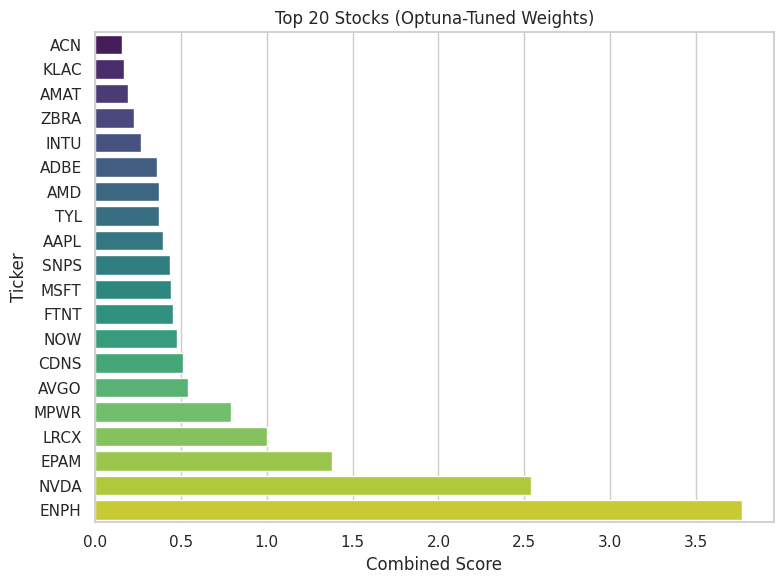

In [ ]:

top_20_sorted = top_20.sort_values("combined_score", ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_20_sorted,
    x="combined_score",
    y="Ticker",
    palette="viridis"
)

plt.title("Top 20 Stocks (Optuna-Tuned Weights)")
plt.xlabel("Combined Score")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()


In [ ]:
!pip install yahooquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.5 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.3.1
    Uninstalling lxml-5.3.1:
      Successfully uninstalled lxml-5.3.1


In [ ]:
import pandas as pd
import numpy as np
from yahooquery import Ticker



fundamental_rows = []

for tkr in top_20['Ticker']:
    try:
        ticker_obj = Ticker(tkr)


        inc_stmt_raw = ticker_obj.income_statement(frequency='q')


        if isinstance(inc_stmt_raw, dict):
            inc_stmt_q = inc_stmt_raw.get(tkr, pd.DataFrame())
        else:
            inc_stmt_q = inc_stmt_raw


        if not inc_stmt_q.empty and 'symbol' not in inc_stmt_q.columns:
            inc_stmt_q = inc_stmt_q.reset_index()
        if 'symbol' not in inc_stmt_q.columns:
            inc_stmt_q['symbol'] = tkr


        inc_stmt_q = inc_stmt_q[inc_stmt_q['asOfDate'] >= '2021-01-01']
        inc_stmt_q.sort_values('asOfDate', ascending=False, inplace=True)

        if inc_stmt_q.empty:
            print(f"No income statement data for {tkr} since 2021-01-01. Skipping.")
            continue


        inc_stmt_ttm = inc_stmt_q.head(4)
        ttm_revenue    = inc_stmt_ttm.get('TotalRevenue', pd.Series()).sum()
        ttm_net_income = inc_stmt_ttm.get('NetIncome', pd.Series()).sum()


        ttm_net_margin = np.nan
        if ttm_revenue and ttm_revenue != 0:
            ttm_net_margin = ttm_net_income / ttm_revenue


        summary = ticker_obj.summary_detail.get(tkr, {})
        trailing_pe = summary.get('trailingPE', np.nan)


        fundamental_rows.append({
            'Ticker': tkr,
            'TTM_Revenue': ttm_revenue,
            'TTM_NetIncome': ttm_net_income,
            'TTM_NetMargin': ttm_net_margin,
            'TrailingPE': trailing_pe
        })

    except Exception as e:
        print(f"Error processing {tkr}: {e}")


fund_df = pd.DataFrame(fundamental_rows)


cols_to_round = ['TTM_Revenue','TTM_NetIncome','TTM_NetMargin','TrailingPE']
for col in cols_to_round:
    if col in fund_df.columns:
        fund_df[col] = fund_df[col].round(2)

print("\n=== Aggregated Fundamental Data (TTM from 2021-01-01) ===")
print(fund_df)



=== Aggregated Fundamental Data (TTM from 2021-01-01) ===
   Ticker   TTM_Revenue  TTM_NetIncome  TTM_NetMargin  TrailingPE
0    ENPH  2.093969e+09   2.105800e+08           0.10       76.44
1    NVDA  2.049100e+11   1.142800e+11           0.56       42.49
2    EPAM  6.950970e+09   6.837790e+08           0.10       26.33
3    LRCX  2.475311e+10   6.601032e+09           0.27       23.33
4    MPWR  3.166997e+09   6.790380e+08           0.21       16.69
5    AVGO  7.870000e+10   8.344000e+09           0.11      153.41
6    CDNS  7.212744e+09   1.633805e+09           0.23       64.90
7     NOW  1.673800e+10   2.241000e+09           0.13      135.14
8    FTNT  9.124000e+09   2.811300e+09           0.31       47.79
9    MSFT  3.970190e+11   1.415250e+11           0.36       31.94
10   SNPS  9.163063e+09   3.519740e+09           0.38       54.96
11   AAPL  6.149900e+11   1.472160e+11           0.24       38.33
12    TYL  3.222271e+09   4.041440e+08           0.13      101.07
13    AMD  4.0262

merged_df shape (performance only): (69, 13)
final_merged shape (performance + fundamentals): (69, 32)
  Ticker  CumulativeReturn_10y  Volatility_10y  ReturnToRisk_10y  \
0    ACN              8.481823        0.227254         37.323151   
1   ADBE             18.848093        0.290675         64.842404   
2    AMD             25.259123        0.576767         43.794353   
3   AKAM              2.554206        0.336724          7.585468   
4    APH              7.333410        0.231111         31.731049   

   CumulativeReturn_5y  Volatility_5y  ReturnToRisk_5y  CumulativeReturn_3y  \
0             2.850627       0.250199        11.393426             2.071274   
1             4.479899       0.330242        13.565517             1.525092   
2            11.589675       0.562022        20.621388             6.642060   
3             0.732130       0.307345         2.382108             0.983393   
4             1.720325       0.250304         6.872953             1.256861   

   Volatility

<ipython-input-26-761da1b491e3>:213: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


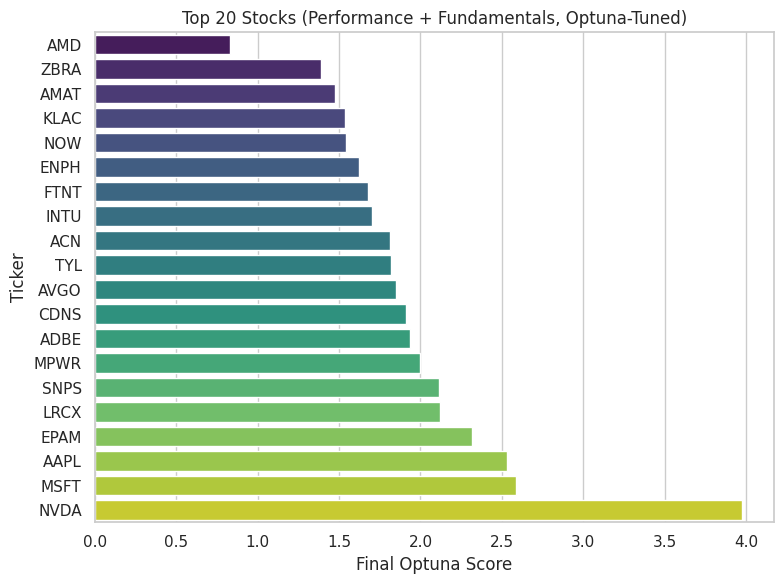

In [ ]:

_results_10y = _results_10y.rename(columns={
    "Cumulative Return": "CumulativeReturn_10y",
    "Volatility":       "Volatility_10y",
    "Return-to-Risk":   "ReturnToRisk_10y"
})
_results_5y = _results_5y.rename(columns={
    "Cumulative Return": "CumulativeReturn_5y",
    "Volatility":       "Volatility_5y",
    "Return-to-Risk":   "ReturnToRisk_5y"
})
_results_3y = _results_3y.rename(columns={
    "Cumulative Return": "CumulativeReturn_3y",
    "Volatility":       "Volatility_3y",
    "Return-to-Risk":   "ReturnToRisk_3y"
})
_results_1y = _results_1y.rename(columns={
    "Cumulative Return": "CumulativeReturn_1y",
    "Volatility":       "Volatility_1y",
    "Return-to-Risk":   "ReturnToRisk_1y"
})


df_10y = _results_10y[["Ticker","CumulativeReturn_10y","Volatility_10y","ReturnToRisk_10y"]]
df_5y  = _results_5y[ ["Ticker","CumulativeReturn_5y","Volatility_5y","ReturnToRisk_5y"]]
df_3y  = _results_3y[ ["Ticker","CumulativeReturn_3y","Volatility_3y","ReturnToRisk_3y"]]
df_1y  = _results_1y[ ["Ticker","CumulativeReturn_1y","Volatility_1y","ReturnToRisk_1y"]]

merged_df = (
    df_10y.merge(df_5y, on="Ticker", how="inner")
          .merge(df_3y, on="Ticker", how="inner")
          .merge(df_1y, on="Ticker", how="inner")
)

print("merged_df shape (performance only):", merged_df.shape)


def zscore(series):
    if series.std(ddof=0) == 0:
        return pd.Series([0]*len(series), index=series.index)
    return (series - series.mean()) / series.std(ddof=0)


cumret_cols = ["CumulativeReturn_10y","CumulativeReturn_5y","CumulativeReturn_3y","CumulativeReturn_1y"]
vol_cols    = ["Volatility_10y","Volatility_5y","Volatility_3y","Volatility_1y"]
rtr_cols    = ["ReturnToRisk_10y","ReturnToRisk_5y","ReturnToRisk_3y","ReturnToRisk_1y"]


for col in cumret_cols + vol_cols + rtr_cols:
    merged_df[f"z_{col}"] = zscore(merged_df[col])

for col in vol_cols:
    merged_df[f"z_{col}"] = -1.0 * merged_df[f"z_{col}"]


final_merged = merged_df.merge(fund_df, on="Ticker", how="left")

def safe_zscore(series):
    if series.std(ddof=0) == 0:
        return pd.Series([0]*len(series), index=series.index)
    return (series - series.mean()) / series.std(ddof=0)


final_merged["z_TTM_Revenue"] = safe_zscore(final_merged["TTM_Revenue"].fillna(0))
final_merged["z_TTM_NetMargin"] = safe_zscore(final_merged["TTM_NetMargin"].fillna(0))


z_pe = safe_zscore(final_merged["TrailingPE"].fillna(9999))
final_merged["z_TrailingPE"] = -1.0 * z_pe

print("final_merged shape (performance + fundamentals):", final_merged.shape)
print(final_merged.head())


def objective(trial):

    w_cr  = trial.suggest_float("w_cr",  0.0, 1.0)
    w_vol = trial.suggest_float("w_vol", 0.0, 1.0)
    w_rtr = trial.suggest_float("w_rtr", 0.0, 1.0)
    sum_perf = w_cr + w_vol + w_rtr
    if sum_perf == 0:
        return -9999
    w_cr  /= sum_perf
    w_vol /= sum_perf
    w_rtr /= sum_perf


    w_rev    = trial.suggest_float("w_rev",    0.0, 1.0)
    w_margin = trial.suggest_float("w_margin", 0.0, 1.0)
    w_pe     = trial.suggest_float("w_pe",     0.0, 1.0)
    sum_fund = w_rev + w_margin + w_pe
    if sum_fund == 0:
        return -9999
    w_rev    /= sum_fund
    w_margin /= sum_fund
    w_pe     /= sum_fund


    w_10y = trial.suggest_float("w_10y", 0.0, 1.0)
    w_5y  = trial.suggest_float("w_5y",  0.0, 1.0)
    w_3y  = trial.suggest_float("w_3y",  0.0, 1.0)
    w_1y  = trial.suggest_float("w_1y",  0.0, 1.0)
    sum_tf = w_10y + w_5y + w_3y + w_1y
    if sum_tf == 0:
        return -9999
    w_10y /= sum_tf
    w_5y  /= sum_tf
    w_3y  /= sum_tf
    w_1y  /= sum_tf

    df = final_merged.copy()

    def combined_score(row):

        perf_10y = (w_cr*row["z_CumulativeReturn_10y"] + w_vol*row["z_Volatility_10y"] + w_rtr*row["z_ReturnToRisk_10y"]) * w_10y
        perf_5y  = (w_cr*row["z_CumulativeReturn_5y"]  + w_vol*row["z_Volatility_5y"]  + w_rtr*row["z_ReturnToRisk_5y"])  * w_5y
        perf_3y  = (w_cr*row["z_CumulativeReturn_3y"]  + w_vol*row["z_Volatility_3y"]  + w_rtr*row["z_ReturnToRisk_3y"])  * w_3y
        perf_1y  = (w_cr*row["z_CumulativeReturn_1y"]  + w_vol*row["z_Volatility_1y"]  + w_rtr*row["z_ReturnToRisk_1y"])  * w_1y
        perf_sum = perf_10y + perf_5y + perf_3y + perf_1y


        fund_sum = (w_rev*row["z_TTM_Revenue"]
                    + w_margin*row["z_TTM_NetMargin"]
                    + w_pe*row["z_TrailingPE"])

        return perf_sum + fund_sum

    df["combined_score"] = df.apply(combined_score, axis=1)


    top_10 = df.nlargest(10, "combined_score")


    avg_rtr_10y   = top_10["ReturnToRisk_10y"].mean()
    avg_netmargin = top_10["z_TTM_NetMargin"].mean()
    objective_value = avg_rtr_10y + avg_netmargin
    return objective_value

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("\nBest hyperparameters:", study.best_params)
print("Best objective value:", study.best_value)


best = study.best_params


w_cr, w_vol, w_rtr = best["w_cr"], best["w_vol"], best["w_rtr"]
sum_perf = w_cr + w_vol + w_rtr
if sum_perf > 0:
    w_cr  /= sum_perf
    w_vol /= sum_perf
    w_rtr /= sum_perf


w_rev, w_margin, w_pe = best["w_rev"], best["w_margin"], best["w_pe"]
sum_fund = w_rev + w_margin + w_pe
if sum_fund > 0:
    w_rev    /= sum_fund
    w_margin /= sum_fund
    w_pe     /= sum_fund


w_10y, w_5y, w_3y, w_1y = best["w_10y"], best["w_5y"], best["w_3y"], best["w_1y"]
sum_tf = w_10y + w_5y + w_3y + w_1y
if sum_tf > 0:
    w_10y /= sum_tf
    w_5y  /= sum_tf
    w_3y  /= sum_tf
    w_1y  /= sum_tf

def final_score(row):
    perf_10y = (w_cr*row["z_CumulativeReturn_10y"] + w_vol*row["z_Volatility_10y"] + w_rtr*row["z_ReturnToRisk_10y"]) * w_10y
    perf_5y  = (w_cr*row["z_CumulativeReturn_5y"]  + w_vol*row["z_Volatility_5y"]  + w_rtr*row["z_ReturnToRisk_5y"])  * w_5y
    perf_3y  = (w_cr*row["z_CumulativeReturn_3y"]  + w_vol*row["z_Volatility_3y"]  + w_rtr*row["z_ReturnToRisk_3y"])  * w_3y
    perf_1y  = (w_cr*row["z_CumulativeReturn_1y"]  + w_vol*row["z_Volatility_1y"]  + w_rtr*row["z_ReturnToRisk_1y"])  * w_1y
    perf_sum = perf_10y + perf_5y + perf_3y + perf_1y

    fund_sum = (w_rev*row["z_TTM_Revenue"]
                + w_margin*row["z_TTM_NetMargin"]
                + w_pe*row["z_TrailingPE"])

    return perf_sum + fund_sum

final_merged["FinalOptunaScore"] = final_merged.apply(final_score, axis=1)
final_merged.sort_values("FinalOptunaScore", ascending=False, inplace=True)

top_20 = final_merged.head(20).copy()
print("\n=== Final Top 20 After Performance + Fundamentals Optuna ===")
print(top_20[["Ticker","FinalOptunaScore","ReturnToRisk_10y","TTM_NetMargin","TrailingPE"]])


import seaborn as sns
import matplotlib.pyplot as plt

top_20_sorted = top_20.sort_values("FinalOptunaScore", ascending=True)
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_20_sorted,
    x="FinalOptunaScore",
    y="Ticker",
    palette="viridis"
)
plt.title("Top 20 Stocks (Performance + Fundamentals, Optuna-Tuned)")
plt.xlabel("Final Optuna Score")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()
